We will simulate Gaussian potential profiles along ideal GBs, then compute the corresponding phase shifts, and through-focus series images. These will be used for performing phase retrieval using differential programming.


In [1]:
#import all the necessary items
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import sys, time
from scipy import ndimage

In [2]:
sys.path.append('/home/connor/Documents/Phase_Reconstruction/')
from microscopes_fwd import Microscope

In [3]:

# Next we generate various GBs with varying levels of potential defined using Gaussian profiles.

# First we define sample parameters
sample_thick = 50 #nm
sample_MIP = 20 # Mean Inner Potential (V) - CeO2 is ~ 19 V
sample_lambda = 100 # Mean free path (nm) for calculating Amplitude


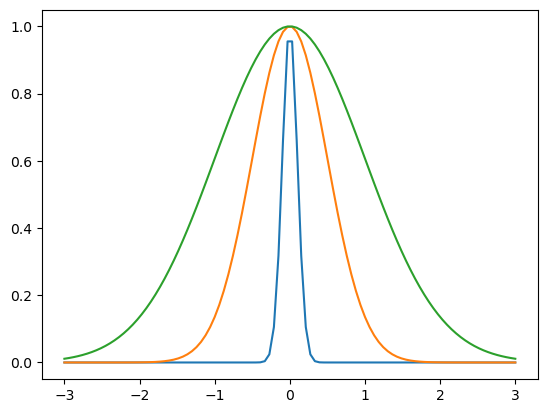

In [4]:
## define a Gaussian function
def gaussian(x, mu, sig, norm=True):
  if norm:
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-0.5*(x-mu)**2/sig**2)
  else:
    return np.exp(-0.5*(x-mu)**2/sig**2)



x = np.linspace(-3,3,100)
plt.plot(x,gaussian(x,0.0,0.1,norm=False))
plt.plot(x,gaussian(x,0.0,0.5,norm=False))
plt.plot(x,gaussian(x,0.0,1,norm=False))
plt.show()

[0.1 0.4 0.7 1. ]
2.6460377906876223e-37 1.0


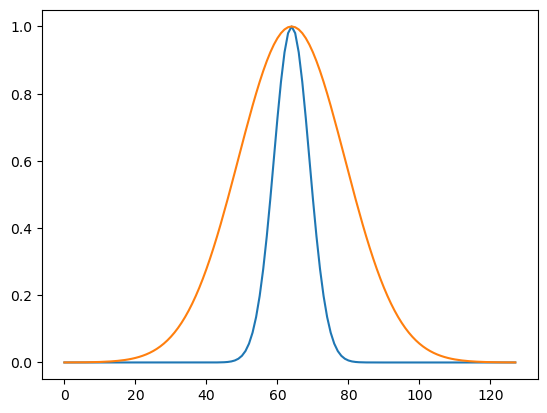

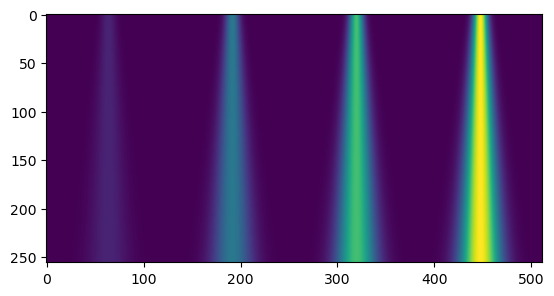

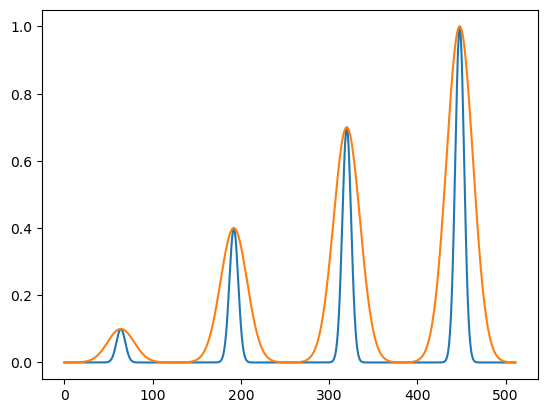

In [7]:
dim = 256
del_px = 0.1 #nm/px
min_sig = 0.5/del_px #px
max_sig = 1.5/del_px #px
sig_var = np.linspace(min_sig, max_sig, dim)
max_gb_len = dim//2
line = np.arange(-max_gb_len/2, max_gb_len/2)
gauss_arr = np.zeros([dim, max_gb_len])
for i in range(dim):
    gauss_arr[i,:] = gaussian(line,0.0, sig_var[i], norm=False)
plt.plot(gauss_arr[0,:])
plt.plot(gauss_arr[-1,:])

GB_pot_vals = np.linspace(0.1, 1.0, 4)
print(GB_pot_vals)

potential_array = np.zeros([dim, 2*dim])
cnt = 0
for i in range(0, 2*dim, max_gb_len):
    potential_array[:, i:i+max_gb_len] = gauss_arr*GB_pot_vals[cnt]
    cnt += 1
plt.figure()
plt.imshow(potential_array)
print(np.amin(potential_array),np.amax(potential_array))
plt.figure()
plt.plot(potential_array[0, :])
plt.plot(potential_array[-1, :])

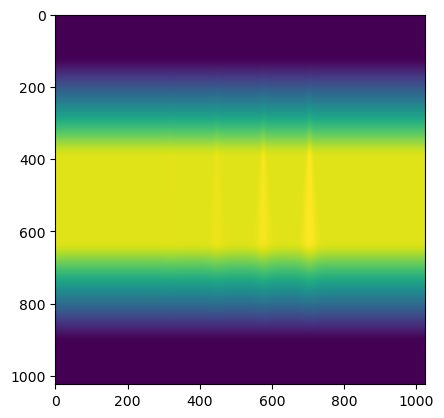

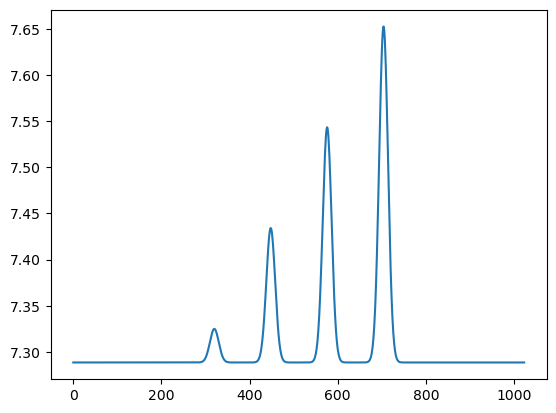

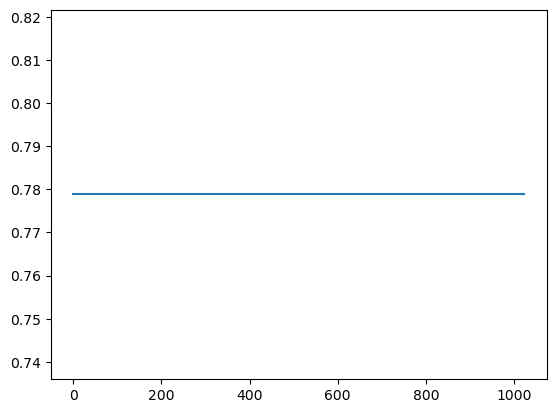

In [39]:
# Next we compute the phase shift
# assumption - the potential is uniform across the thickness of the sample.

#create a microscope instance
TEM = Microscope(Cs = 1.0e6, theta_c = 0.1e-3, def_spr = 5)

dim = 1024
t_map = sample_thick*np.ones((dim, dim))
d4 = dim//4
d8 = dim//8

#slope sample edge
t_map[:d8,:] = 0
t_map[-d8:,:] = 0
t_map[d8:d8+d4, np.arange(t_map.shape[1])] = np.linspace(0, sample_thick, d4).reshape((d4,1))
t_map[-d8-d4:-d8, np.arange(t_map.shape[1])] = np.linspace(sample_thick, 0, d4).reshape((d4,1))

#Add low-frequency thickness variation
#t_map = 2*t_map*np.random.random([dim, dim])
t_map = ndimage.gaussian_filter(t_map, 10, order=0, mode='wrap')
#t_map[:d2,:] = 0
#t_map[-d2:,:] = 0

# calculate the phase and amplitude and then the object wave
potential = np.zeros((dim, dim))
potential[d4+d8:-d4-d8, d4:-d4] += potential_array
potential[np.arange(0, d4+d8), d4:-d4] = potential_array[0,:]
potential[np.arange(-d4-d8, 0), d4:-d4] = potential_array[-1,:]
potential += sample_MIP*np.ones((dim,dim))

Phase = TEM.sigma * t_map * potential
Amplitude = np.exp(-0.5*t_map/sample_lambda)

plt.imshow(Phase)

plt.figure()
plt.plot(Phase[512,:])

plt.figure()
plt.plot(Amplitude[512,:])

#define the object wave
ObjWave = Amplitude * (np.cos(Phase) + 1j * np.sin(Phase))

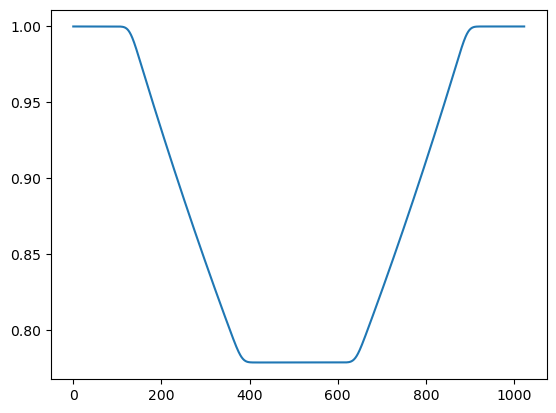

In [40]:
plt.plot(Amplitude[:, 512])

In [58]:
np.save('/home/connor/Documents/Phase_Reconstruction/true_phase', Phase)
np.save('/home/connor/Documents/Phase_Reconstruction/true_amp', Amplitude)

In [41]:
TEM = Microscope(Cs = 1.0e6, theta_c = 0.1e-3, def_spr = 5)

/tmp/ipykernel_35067/1656760385.py:2: RuntimeWarning: invalid value encountered in divide
  true_potential = Phase / (TEM.sigma*true_thickness)


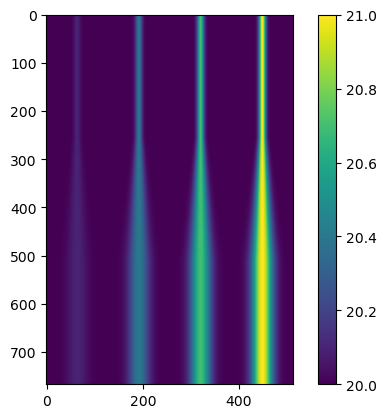

In [42]:
true_thickness = np.log(Amplitude)*-200
true_potential = Phase / (TEM.sigma*true_thickness)
plt.imshow(true_potential[128:-128, 256:-256])
plt.colorbar()

In [57]:
#Setup reciprocal space vectors for image simulation
#reciprocal space vectors
dim = 1024
d2=dim//2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 0.1 #nm/px

TEM.setAperture(qq, del_px, 0.5) #0.5 nm aperture

#Exponential defocus series
index = np.arange(1.2, 6.2, 0.2)
defocus=np.zeros(2*len(index)+1)
defocus[-len(index):] = 10**index
index = np.flip(index)
defocus[:len(index)] = -10**index
print("Defocus values: ",defocus)
n_def = len(defocus)

imgstack = np.zeros([n_def,dim,dim])
for i in range(n_def):
    TEM.defocus = defocus[i]
    imgstack[i,:,:] = TEM.getImage(ObjWave, qq, del_px)

Defocus values:  [-1.00000000e+06 -6.30957344e+05 -3.98107171e+05 -2.51188643e+05
 -1.58489319e+05 -1.00000000e+05 -6.30957344e+04 -3.98107171e+04
 -2.51188643e+04 -1.58489319e+04 -1.00000000e+04 -6.30957344e+03
 -3.98107171e+03 -2.51188643e+03 -1.58489319e+03 -1.00000000e+03
 -6.30957344e+02 -3.98107171e+02 -2.51188643e+02 -1.58489319e+02
 -1.00000000e+02 -6.30957344e+01 -3.98107171e+01 -2.51188643e+01
 -1.58489319e+01  0.00000000e+00  1.58489319e+01  2.51188643e+01
  3.98107171e+01  6.30957344e+01  1.00000000e+02  1.58489319e+02
  2.51188643e+02  3.98107171e+02  6.30957344e+02  1.00000000e+03
  1.58489319e+03  2.51188643e+03  3.98107171e+03  6.30957344e+03
  1.00000000e+04  1.58489319e+04  2.51188643e+04  3.98107171e+04
  6.30957344e+04  1.00000000e+05  1.58489319e+05  2.51188643e+05
  3.98107171e+05  6.30957344e+05  1.00000000e+06]


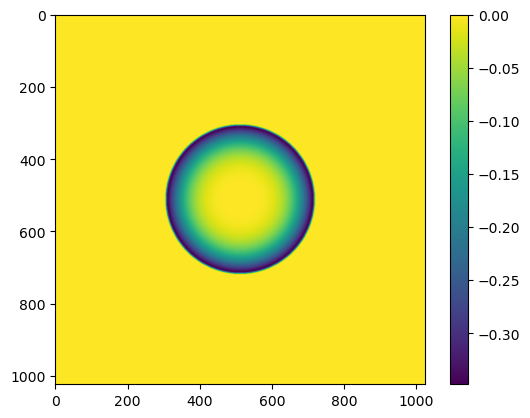

In [59]:
TEM.defocus=0
tf = TEM.getTransferFunction(qq, del_px)
plt.imshow(tf.imag)
plt.colorbar()

In [60]:
np.save('/home/connor/Documents/Phase_Reconstruction/Sim_Images/imgstack_ap_noise0', imgstack)

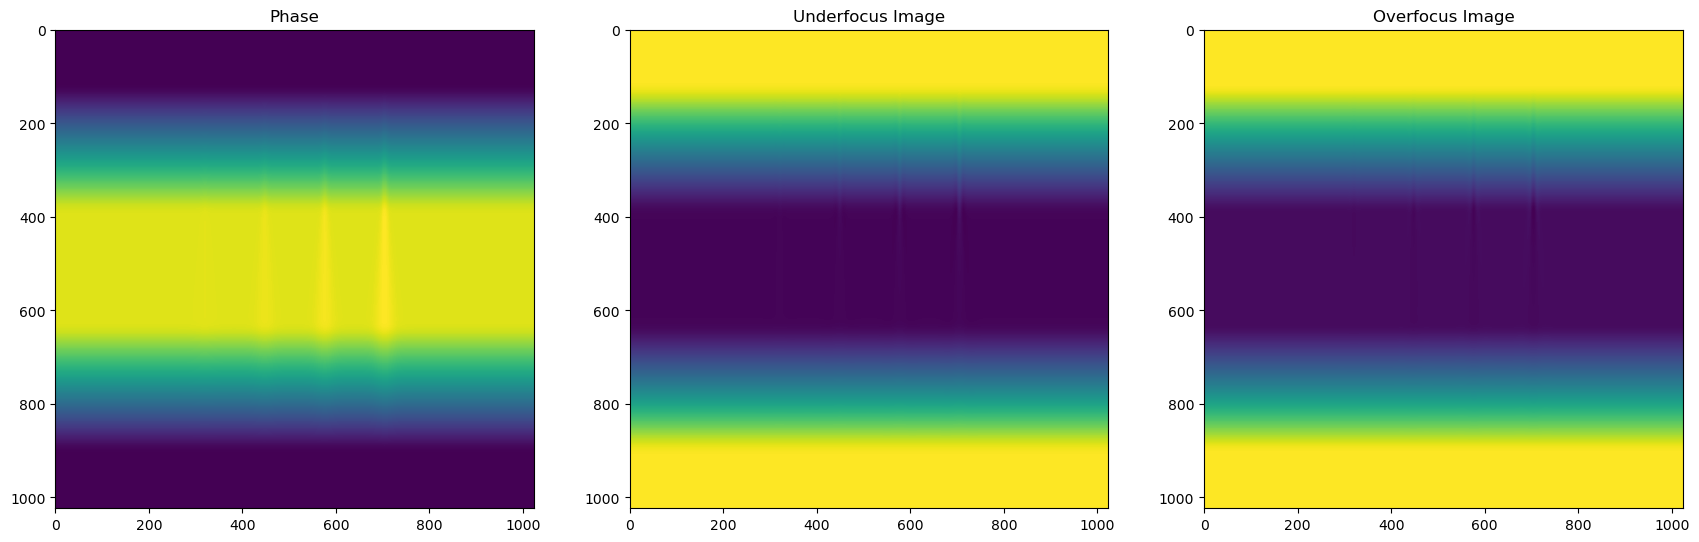

In [61]:
f, ax = plt.subplots(ncols=3, figsize = (21,8))
ax[0].imshow(Phase, interpolation='none')
ax[0].set_title("Phase")
ax[1].imshow(imgstack[22,:,:], interpolation='none')
ax[1].set_title("Underfocus Image");
ax[2].imshow(imgstack[28,:,:], interpolation='none')
ax[2].set_title("Overfocus Image");


In [63]:
factor = Amplitude[384:-384,:].mean()**2

In [65]:
def make_pnoise(image, noise_level):
            lam = 1/(factor*noise_level**2)
            image_n_filt = np.random.poisson(image * lam) / float(lam)
            return image_n_filt

noise_vals = np.array([0.02, 0.05, 0.1, 0.2])
imgstack_noise = np.zeros([noise_vals.size, 51, 1024, 1024])
for i in range(len(noise_vals)):
    for j in range(51):
        imgstack_noise[i,j,:,:] = make_pnoise(imgstack[j,:,:], noise_vals[i])

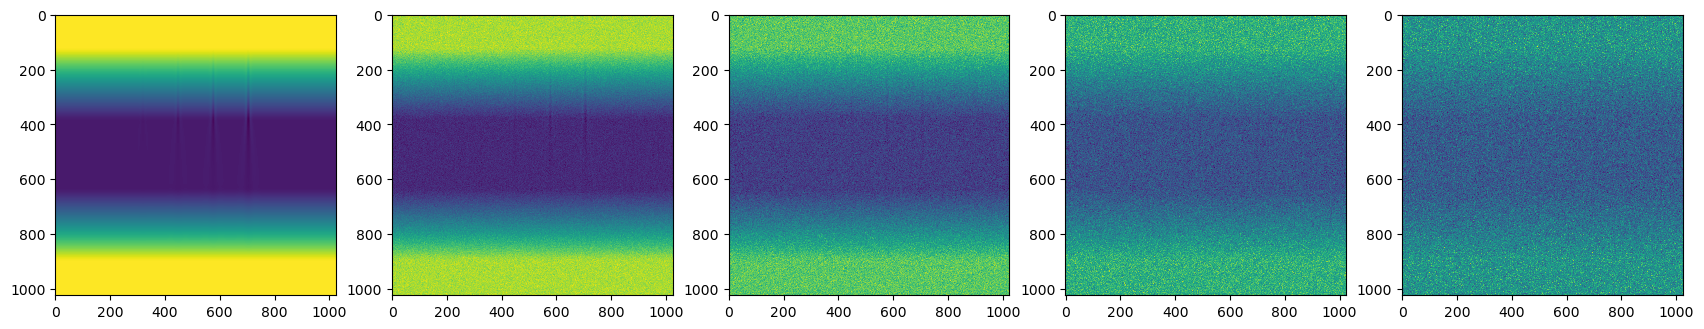

In [66]:
f, axs = plt.subplots(ncols=5, figsize = (21,8))
axs[0].imshow(imgstack[30,:,:], interpolation='none')
axs[1].imshow(imgstack_noise[0,30,:,:], interpolation='none')
axs[2].imshow(imgstack_noise[1,30,:,:], interpolation='none')
axs[3].imshow(imgstack_noise[2,30,:,:], interpolation='none')
axs[4].imshow(imgstack_noise[3,30,:,:], interpolation='none')

In [67]:
print(((imgstack_noise[0,25,384:-384,256:-256]-imgstack[25,384:-384,256:-256])/imgstack[25,384:-384,256:-256]).std()*100)
print(((imgstack_noise[1,25,384:-384,256:-256]-imgstack[25,384:-384,256:-256])/imgstack[25,384:-384,256:-256]).std()*100)
print(((imgstack_noise[2,25,384:-384,256:-256]-imgstack[25,384:-384,256:-256])/imgstack[25,384:-384,256:-256]).std()*100)
print(((imgstack_noise[3,25,384:-384,256:-256]-imgstack[25,384:-384,256:-256])/imgstack[25,384:-384,256:-256]).std()*100)

1.9975521294816654
5.0052892440989964
10.038307758853305
19.988709717290583


In [68]:
np.save('/home/connor/Documents/Phase_Reconstruction/Sim_Images/imgstack_ap_noise2', imgstack_noise[0,:,:,:])
np.save('/home/connor/Documents/Phase_Reconstruction/Sim_Images/imgstack_ap_noise5', imgstack_noise[1,:,:,:])
np.save('/home/connor/Documents/Phase_Reconstruction/Sim_Images/imgstack_ap_noise10', imgstack_noise[2,:,:,:])
np.save('/home/connor/Documents/Phase_Reconstruction/Sim_Images/imgstack_ap_noise20', imgstack_noise[3,:,:,:])